In [1]:
from pathlib import Path
import pandas as pd
import json
# import pickle
# from mirar.processors.sources.source_loader import load_source_table
# from mirar.processors.sources.source_exporter import save_source_table
# from mirar.data.utils import decode_img
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
# from astropy import visualization
# from astropy.io import fits
# from astropy.time import Time
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages

import fastavro
from fastavro import reader
# %matplotlib inline

from winterdrb.paths import get_combined_avro_path, get_pdf_path
from winterdrb.utils import parse_night_data
from winterdrb.plot import generate_single_page
from winterdrb.models import RealBogus
from winterdrb.filtering import apply_clean_filter
from winterdrb.database.populate import populate_night
from tqdm import tqdm
import numpy as np
from astropy.time import Time

# from winterdrb.filtering

In [2]:
neutrino_localisation_ra = ["72.69", "+1.92", "-1.85"]
neutrino_localisation_dec = ["+11.42", "+0.50", "-0.44"]

In [3]:
# night = "20240112"
nights = ["20240105", "20240106", "20240112", "20240116"]

all_res = []

for night in sorted(nights):
    all_res.append(parse_night_data(night))

all_res = pd.concat(all_res)

In [4]:
neutrino_ra_up = float(neutrino_localisation_ra[0]) + float(neutrino_localisation_ra[1])
neutrino_ra_down = float(neutrino_localisation_ra[0]) + float(neutrino_localisation_ra[2])
neutrino_dec_up = float(neutrino_localisation_dec[0]) + float(neutrino_localisation_dec[1])
neutrino_dec_down = float(neutrino_localisation_dec[0]) + float(neutrino_localisation_dec[2])

mask = (all_res["ra"] > neutrino_ra_down) & (all_res["ra"] < neutrino_ra_up) & (all_res["dec"] > neutrino_dec_down) & (all_res["dec"] < neutrino_dec_up)

print(f"Limits are {neutrino_ra_down}-{neutrino_ra_up} and {neutrino_dec_down}-{neutrino_dec_up}")

print(f"{np.sum(mask)} out of {len(mask)} alerts in localisation")
res = all_res[mask]

Limits are 70.84-74.61 and 10.98-11.92
10789 out of 61608 alerts in localisation


In [5]:
print([x for x in res.columns])

['objectid', 'cutout_science', 'cutout_template', 'cutout_difference', 'prv_candidates', 'candid', 'deprecated', 'jd', 'fid', 'exptime', 'ndethist', 'jdstarthist', 'jdendhist', 'progname', 'programid', 'isdiffpos', 'field', 'ra', 'dec', 'magzpsci', 'magzpsciunc', 'magzpscirms', 'diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap', 'magapbig', 'sigmagapbig', 'magdiff', 'magfromlim', 'distnr', 'magnr', 'sigmagnr', 'xpos', 'ypos', 'sky', 'fwhm', 'classtar', 'mindtoedge', 'seeratio', 'aimage', 'bimage', 'aimagerat', 'bimagerat', 'elong', 'nneg', 'nbad', 'sumrat', 'dsnrms', 'ssnrms', 'dsdiff', 'scorr', 'clrcoeff', 'clrcounc', 'zpclrcov', 'zpmed', 'clrmed', 'clrrms', 'rb', 'rbversion', 'ssdistnr', 'ssmagnr', 'ssnamenr', 'tooflag', 'nmtchps', 'psra1', 'psdec1', 'psobjectid1', 'sgmag1', 'srmag1', 'simag1', 'szmag1', 'sgscore1', 'distpsnr1', 'psobjectid2', 'sgmag2', 'srmag2', 'simag2', 'szmag2', 'sgscore2', 'distpsnr2', 'psobjectid3', 'sgmag3', 'srmag3', 'simag3', 'szmag3', 'sgscor

In [48]:
ann_fields = [
    "ra", "dec", "fid", "field",  "candid",
    "neargaia", 'neargaiabright', 'maggaia', 'maggaiabright', 
    "distpsnr1", "tmjmag1",
    "nneg", "elong", "fwhm",  "sumrat",
    "magzpsci", "magap", "magapbig", "magdiff", "magfromlim",
    "classtar", "nbad", "nmtchps", "scorr", "chipsf", "mindtoedge"
]

def deduplicate_df(df):
    new_df = []
    for name in list(set(df["objectid"])):
        mask = df["objectid"] == name
        new_df.append(df[mask].iloc[-1])
    
    return pd.concat(new_df, axis=1).transpose()

def mpc_format(df, name):

    sub_df = df[df["objectid"] == name]
    
    for _, row in sub_df.iterrows():
        t = Time(row["jd"], format="jd")
        t.format = "isot"

        frac_days = f"{t.mjd - int(t.mjd):.2f}"[1:]
        t.out_subfmt = "date"

        dt = "".join([t.value, frac_days])
        
        print(f"{row['objectid']}:  {dt} \n {row['ra']}, {row['dec']}")

In [7]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(res.iloc[0])

In [8]:
res

objectid                                     cutout_science  \
1452   WNTR24aaaaa  b'\x1f\x8b\x08\x00b\x7f\x99e\x02\xff\xec\xbby8...   
1453   WNTR24aaaab  b'\x1f\x8b\x08\x00b\x7f\x99e\x02\xff\xec\xbay8...   
1454   WNTR24aaaac  b'\x1f\x8b\x08\x00c\x7f\x99e\x02\xff\xed\xbcy<...   
1455   WNTR24aaaad  b'\x1f\x8b\x08\x00e\x7f\x99e\x02\xff\xed\xbcy<...   
1456   WNTR24aaaae  b'\x1f\x8b\x08\x00e\x7f\x99e\x02\xff\xed|y8\x9...   
...            ...                                                ...   
15482  WNTR24aaajv  b'\x1f\x8b\x08\x00\x92^\xa8e\x02\xff\xec\x98i4...   
15483  WNTR24aaajw  b'\x1f\x8b\x08\x00\x94^\xa8e\x02\xff\xec\x99y4...   
15484  WNTR24aaajx  b'\x1f\x8b\x08\x00\x98^\xa8e\x02\xff\xec\x97y4...   
15485  WNTR24aaajy  b'\x1f\x8b\x08\x00\x9c^\xa8e\x02\xff\xed\x9cyT...   
16621  WNTR24aabjh  b'\x1f\x8b\x08\x00\x92_\xa8e\x02\xff\xec\x97y4...   

                                         cutout_template  \
1452   b'\x1f\x8b\x08\x00b\x7f\x99e\x02\xff\xec\xbby8...   
1453   b'\x1f\x8b\x08\x00b\x7f\x99e\x02\xff\xec\xb9i8...   
1454   b'\x1f\x8b\x08\x00c\x7f\x99e\x02\xff\xed\xbcy\...   
1455   b'\x1f\x8b\x08\x00e\x7f\x99e\x02\xff\xed\xbcy<...   
1456   b'\x1f\x8b\x08\x00e\x7f\x99e\x02\xff\xed{yXN]\...   
...                                                  ...   
15482  b'\x1f\x8b\x08\x00\x92^\xa8e\x02\xff\xec\x97iP...   
15483  b'\x1f\x8b\x08\x00\x94^\xa8e\x02\xff\xeczi4W\x...   
15484  b'\x1f\x8b\x08\x00\x98^\xa8e\x02\xff\xec\xb7i0...   
15485  b'\x1f\x8b\x08\x00\x9c^\xa8e\x02\xff\xed\x9cy4...   
16621  b'\x1f\x8b\x08\x00\x92_\xa8e\x02\xff\xec\x97\x...   

                                       cutout_difference  \
1452   b'\x1f\x8b\x08\x00b\x7f\x99e\x02\xff\xec\xbdgP...   
1453   b'\x1f\x8b\x08\x00b\x7f\x99e\x02\xff\xec\xbcWP...   
1454   b'\x1f\x8b\x08\x00c\x7f\x99e\x02\xff\xec\xbceT...   
1455   b'\x1f\x8b\x08\x00e\x7f\x99e\x02\xff\xec\xbdgP...   
1456   b'\x1f\x8b\x08\x00e\x7f\x99e\x02\xff\xec\xbcWT...   
...                                                  ...   
15482  b'\x1f\x8b\x08\x00\x92^\xa8e\x02\xff\xec\x9bi4...   
15483  b'\x1f\x8b\x08\x00\x94^\xa8e\x02\xff\xec\x97y4...   
15484  b'\x1f\x8b\x08\x00\x98^\xa8e\x02\xff\xec\xb7i4...   
15485  b'\x1f\x8b\x08\x00\x9c^\xa8e\x02\xff\xec\xdcw4...   
16621  b'\x1f\x8b\x08\x00\x92_\xa8e\x02\xff\xec\x97\x...   

                                          prv_candidates   candid  deprecated  \
1452                jd     magpsf  sigmapsf
0  2.4603...  1068437       False   
1453                jd     magpsf  sigmapsf
0  2.4603...  1068438       False   
1454                jd     magpsf  sigmapsf
0  2.4603...  1068439       False   
1455                jd     magpsf  sigmapsf
0  2.4603...  1068440       False   
1456                jd     magpsf  sigmapsf
0  2.4603...  1068441       False   
...                                                  ...      ...         ...   
15482               jd     magpsf  sigmapsf
0  2.4603...  1121554       False   
15483               jd     magpsf  sigmapsf
0  2.4603...  1121555       False   
15484               jd     magpsf  sigmapsf
0  2.4603...  1121556       False   
15485               jd     magpsf  sigmapsf
0  2.4603...  1121557       False   
16621               jd     magpsf  sigmapsf
0  2.4603...  1123013       False   

                 jd  fid  exptime  ...  tmkmag2        tmobjectid2  tmjmag3  \
1452   2.460316e+06    2   2400.0  ...      NaN                nan      NaN   
1453   2.460316e+06    2   2400.0  ...      NaN                nan      NaN   
1454   2.460316e+06    2   2400.0  ...      NaN                nan      NaN   
1455   2.460316e+06    2   2400.0  ...      NaN                nan      NaN   
1456   2.460316e+06    2   2400.0  ...      NaN                nan      NaN   
...             ...  ...      ...  ...      ...                ...      ...   
15482  2.460327e+06    2   1200.0  ...   14.909  04555932+1145046    12.905   
15483  2.460327e+06    2   1200.0  ...   15.819  04551717+1143264    14.684   
15484  

In [9]:
# cut = cut.iloc[:30]
ztf_dir = r"/Users/robertstein/Data/nuztf/cache/candidates/Update_of_IceCube-240105A"
ztf_cache = Path(ztf_dir).joinpath("initial_stage.json")
assert ztf_cache.exists()

In [10]:
with open(ztf_cache, "r") as f:
    res_ztf = json.load(f)

In [11]:
res_ztf

[{'candid': 2563112211815015002,
  'objectId': 'ZTF23abnbspj',
  'schemavsn': '4.02',
  'publisher': 'Ampel',
  'candidate': {'jd': 2460317.6122106,
   'fid': 1,
   'pid': 2563112211815,
   'diffmaglim': 20.050582885742188,
   'programid': 2,
   'candid': 2563112211815015002,
   'isdiffpos': 't',
   'tblid': 2,
   'nid': 2563,
   'rcid': 18,
   'field': 509,
   'xpos': 1933.1639404296875,
   'ypos': 1175.0208740234375,
   'ra': 73.9045207,
   'dec': 10.4861847,
   'magpsf': 18.16717529296875,
   'sigmapsf': 0.08094726502895355,
   'chipsf': 1.898627519607544,
   'magap': 18.457700729370117,
   'sigmagap': 0.1014999970793724,
   'distnr': 0.8267754912376404,
   'magnr': 14.500999450683594,
   'sigmagnr': 0.01899999938905239,
   'chinr': 0.6259999871253967,
   'sharpnr': -0.02800000086426735,
   'sky': 0.00560852000489831,
   'magdiff': 0.29052498936653137,
   'fwhm': 1.6325352191925049,
   'classtar': 0.9629999995231628,
   'mindtoedge': 1139.3360595703125,
   'magfromlim': 1.5928835868

In [12]:
ztf_sources = []

for entry in res_ztf:

    new_dict = {}
    
    for field in ["candid", "objectId"]:
        new_dict[field] = entry[field]

    for key, val in entry["candidate"].items():
        new_dict[key] = val

    ztf_sources.append(new_dict)

ztf_df = pd.DataFrame(ztf_sources)
ztf_df

candid      objectId            jd  fid            pid  \
0     2563112211815015002  ZTF23abnbspj  2.460318e+06    1  2563112211815   
1     2571175092715015000  ZTF24aackayf  2.460326e+06    2  2571175092715   
2     2561261124315010003  ZTF18aczussw  2.460316e+06    2  2561261124315   
3     2569258581615015014  ZTF18ackzorg  2.460324e+06    2  2569258581615   
4     2569253652415010001  ZTF17aadqexw  2.460324e+06    1  2569253652415   
...                   ...           ...           ...  ...            ...   
1390  2561261123515010018  ZTF23abtgity  2.460316e+06    2  2561261123515   
1391  2561110391715015020  ZTF24aaalyho  2.460316e+06    2  2561110391715   
1392  2561261122015010030  ZTF18aaaajmw  2.460316e+06    2  2561261122015   
1393  2567134281715015004  ZTF24aabnjwy  2.460322e+06    1  2567134281715   
1394  2561283396015015003  ZTF24aaaomxx  2.460316e+06    2  2561283396015   

      diffmaglim  programid isdiffpos  tblid   nid  ...      zpmed  clrmed  \
0      20.050583          2         t      2  2563  ...  26.209999   0.714   
1      20.077351          1         t      0  2571  ...  26.368000   0.744   
2      21.529388          2         f      3  2561  ...  28.993000   0.816   
3      19.673992          1         t     14  2569  ...  26.162001   0.640   
4      19.423679          2         f      1  2569  ...  25.802999   0.827   
...          ...        ...       ...    ...   ...  ...        ...     ...   
1390   21.579350          2         f     18  2561  ...  28.921000   0.730   
1391   21.096626          2         t     20  2561  ...  28.832001   0.700   
1392   21.584618          2         f     30  2561  ...  28.924999   0.748   
1393   20.141640          2         t      4  2567  ...  26.188999   0.687   
1394   20.254704          2         t      3  2561  ...  26.218000   0.683   

        clrrms   neargaia  neargaiabright    maggaia  maggaiabright  exptime  \
0     0.217487   0.886120        0.886120  13.670504      13.670504     30.0   
1     0.271828   1.912933       73.153938  16.794041      13.599230     30.0   
2     0.248322   0.604325     -999.000000  15.991595    -999.000000    300.0   
3     0.224323   0.317012       58.330421  14.876080      13.338897     30.0   
4     0.197915   0.237662     -999.000000  15.769139    -999.000000     30.0   
...        ...        ...             ...        ...            ...      ...   
1390  0.241651   0.414057     -999.000000  20.256063    -999.000000    300.0   
1391  0.245692  32.233341       66.778854  19.360952      12.377949    300.0   
1392  0.240163   0.194050       68.803299  16.536785      13.791586    300.0   
1393  0.218652  33.671230       86.525597  17.440548      13.917184     30.0   
1394  0.226948  12.084079     -999.000000  19.951956    -999.000000     30.0   

           drb  drbversion  
0     0.907457       d6_m7  
1     0.994704       d6_m7  
2     0.999999       d6_m7  
3     0.999782       d6_m7  
4     0.999999       d6_m7  
...        ...         ...  
1390  0.995134       d6_m7  
1391  0.999954       d6_m7  
1392  0.999999       d6_m7  
1393  0.999987       d6_m7  
1394  0.999729       d6_m7  

[1395 rows x 102 columns]

In [13]:
ztf_positions = SkyCoord(ztf_df["ra"].to_numpy()*u.deg, ztf_df["dec"].to_numpy()*u.deg, frame='icrs')
ztf_positions

<SkyCoord (ICRS): (ra, dec) in deg
    [(73.9045207, 10.4861847), (71.035626 , 10.7746737),
     (71.0456265, 12.4850988), ..., (72.864385 , 10.9644519),
     (74.2723365, 11.4354165), (74.7879348, 11.7848017)]>

In [14]:
winter_positions = SkyCoord(res["ra"].to_numpy()*u.deg, res["dec"].to_numpy()*u.deg, frame='icrs')
idx, d2d, _ = winter_positions.match_to_catalog_sky(ztf_positions)

crossmatch_radius = 3.0 * u.arcsec
mask = d2d < crossmatch_radius

In [15]:
cut = res[mask]
cut.reset_index(inplace=True)
cut

index     objectid                                     cutout_science  \
0    1553  WNTR24aaadx  b'\x1f\x8b\x08\x00\xb7\x7f\x99e\x02\xff\xec\x9...   
1   10052  WNTR24aabfj  b'\x1f\x8b\x08\x00\x07\x83\x99e\x02\xff\xec\xb...   
2   10345  WNTR24aabqq  b'\x1f\x8b\x08\x000\x83\x99e\x02\xff\xec\x9b\x...   
3   12955  WNTR24aaago  b'\x1f\x8b\x08\x00\xcd\x81\x99e\x02\xff\xec\x9...   
4   23694  WNTR24aacys  b'\x1f\x8b\x08\x00\x7f\x83\x99e\x02\xff\xec\xb...   
5    1404  WNTR24aabos  b'\x1f\x8b\x08\x00\xb9\xc2\x9ae\x02\xff\xec\x9...   
6    7141  WNTR24aabhq  b'\x1f\x8b\x08\x00\xb0\xc2\x9ae\x02\xff\xec\x9...   
7    7364  WNTR24aabfj  b'\x1f\x8b\x08\x00\xca\xc2\x9ae\x02\xff\xec\x9...   
8    1829  WNTR24aaaip  b'\x1f\x8b\x08\x00\x8fG\xa4e\x02\xff\xec\x97\x...   
9    3367  WNTR24aaaod  b'\x1f\x8b\x08\x00t^\xa8e\x02\xff\xec\x97i4\x9...   
10   7001  WNTR24aaaux  b'\x1f\x8b\x08\x00\xe1^\xa8e\x02\xff\xec\x97\x...   
11   7750  WNTR24aaaiv  b'\x1f\x8b\x08\x00\x14]\xa8e\x02\xff\xec\x97\x...   
12  10727  WNTR24aabfj  b'\x1f\x8b\x08\x00J^\xa8e\x02\xff\xec\x97i4W\x...   
13  15466  WNTR24aaajf  b'\x1f\x8b\x08\x00`^\xa8e\x02\xff\xec\x97\xf97...   

                                      cutout_template  \
0   b'\x1f\x8b\x08\x00\xb7\x7f\x99e\x02\xff\xec\x9...   
1   b'\x1f\x8b\x08\x00\x07\x83\x99e\x02\xff\xec\x9...   
2   b'\x1f\x8b\x08\x000\x83\x99e\x02\xff\xec\x97\x...   
3   b'\x1f\x8b\x08\x00\xcd\x81\x99e\x02\xff\xec\x9...   
4   b'\x1f\x8b\x08\x00\x7f\x83\x99e\x02\xff\xec\xb...   
5   b'\x1f\x8b\x08\x00\xb9\xc2\x9ae\x02\xff\xec\x9...   
6   b'\x1f\x8b\x08\x00\xb0\xc2\x9ae\x02\xff\xec\x9...   
7   b'\x1f\x8b\x08\x00\xca\xc2\x9ae\x02\xff\xec\x9...   
8   b'\x1f\x8b\x08\x00\x8fG\xa4e\x02\xff\xec\x97i4...   
9   b'\x1f\x8b\x08\x00t^\xa8e\x02\xff\xec\x97i4V\x...   
10  b'\x1f\x8b\x08\x00\xe1^\xa8e\x02\xff\xec\x97i4...   
11  b'\x1f\x8b\x08\x00\x14]\xa8e\x02\xff\xec\x97i4...   
12  b'\x1f\x8b\x08\x00J^\xa8e\x02\xff\xec\x97\xf97...   
13  b'\x1f\x8b\x08\x00`^\xa8e\x02\xff\xec\x97iT\x8...   

                                    cutout_difference  \
0   b'\x1f\x8b\x08\x00\xb7\x7f\x99e\x02\xff\xecww8...   
1   b'\x1f\x8b\x08\x00\x07\x83\x99e\x02\xff\xeczi4...   
2   b'\x1f\x8b\x08\x000\x83\x99e\x02\xff\xecxy4\x9...   
3   b'\x1f\x8b\x08\x00\xcd\x81\x99e\x02\xff\xec\x9...   
4   b'\x1f\x8b\x08\x00\x7f\x83\x99e\x02\xff\xec\xb...   
5   b'\x1f\x8b\x08\x00\xb9\xc2\x9ae\x02\xff\xec\x9...   
6   b'\x1f\x8b\x08\x00\xb0\xc2\x9ae\x02\xff\xec\x9...   
7   b'\x1f\x8b\x08\x00\xca\xc2\x9ae\x02\xff\xec\x9...   
8   b'\x1f\x8b\x08\x00\x8fG\xa4e\x02\xff\xec{WPUa\...   
9   b'\x1f\x8b\x08\x00t^\xa8e\x02\xff\xec\x9bi4\x9...   
10  b'\x1f\x8b\x08\x00\xe1^\xa8e\x02\xff\xecw\xf97...   
11  b'\x1f\x8b\x08\x00\x14]\xa8e\x02\xff\xecwy4\x9...   
12  b'\x1f\x8b\x08\x00J^\xa8e\x02\xff\xec\x97y4\x9...   
13  b'\x1f\x8b\x08\x00`^\xa8e\x02\xff\xecy\xf97\xd...   

                                       prv_candidates   candid  deprecated  \
0                jd     magpsf  sigmapsf
0  2.4603...  1068538       False   
1                jd     magpsf  sigmapsf
0  2.4603...  1095740       False   
2                jd     magpsf  sigmapsf
0  2.4603...  1096033       False   
3                jd     magpsf  sigmapsf
0  2.4603...  1092337       False   
4                jd     magpsf  sigmapsf
0  2.4603...  1083112       False   
5                jd     magpsf  sigmapsf
0  2.4603...  1102953       False   
6                jd     magpsf  sigmapsf
0  2.4603...  1100998       False   
7         candid  progname            jd  fid isdi...  1101221       False   
8                jd     magpsf  sigmapsf
0  2.4603...  1116621       False   
9                jd     magpsf  sigmapsf
0  2.4603...  1122196       False   
10               jd     magpsf  sigmapsf
0  2.4603...  1121879       False   
11               jd     magpsf  sigmapsf
0  2.4603...  1121461       False   
12        candid  progname            jd  fid isdi...  1123198       False   
13               jd    magpsf  sigmapsf
0  2

In [16]:
ztf_names = []

for id in idx[mask]:
    ztf_names.append(ztf_df["objectId"].iloc[id])

cut = cut.assign(ztf_name=ztf_names)

In [17]:
# # deduplicate
cut = deduplicate_df(cut)
cut

index     objectid                                     cutout_science  \
2   10345  WNTR24aabqq  b'\x1f\x8b\x08\x000\x83\x99e\x02\xff\xec\x9b\x...   
11   7750  WNTR24aaaiv  b'\x1f\x8b\x08\x00\x14]\xa8e\x02\xff\xec\x97\x...   
0    1553  WNTR24aaadx  b'\x1f\x8b\x08\x00\xb7\x7f\x99e\x02\xff\xec\x9...   
6    7141  WNTR24aabhq  b'\x1f\x8b\x08\x00\xb0\xc2\x9ae\x02\xff\xec\x9...   
8    1829  WNTR24aaaip  b'\x1f\x8b\x08\x00\x8fG\xa4e\x02\xff\xec\x97\x...   
9    3367  WNTR24aaaod  b'\x1f\x8b\x08\x00t^\xa8e\x02\xff\xec\x97i4\x9...   
12  10727  WNTR24aabfj  b'\x1f\x8b\x08\x00J^\xa8e\x02\xff\xec\x97i4W\x...   
5    1404  WNTR24aabos  b'\x1f\x8b\x08\x00\xb9\xc2\x9ae\x02\xff\xec\x9...   
3   12955  WNTR24aaago  b'\x1f\x8b\x08\x00\xcd\x81\x99e\x02\xff\xec\x9...   
13  15466  WNTR24aaajf  b'\x1f\x8b\x08\x00`^\xa8e\x02\xff\xec\x97\xf97...   
10   7001  WNTR24aaaux  b'\x1f\x8b\x08\x00\xe1^\xa8e\x02\xff\xec\x97\x...   
4   23694  WNTR24aacys  b'\x1f\x8b\x08\x00\x7f\x83\x99e\x02\xff\xec\xb...   

                                      cutout_template  \
2   b'\x1f\x8b\x08\x000\x83\x99e\x02\xff\xec\x97\x...   
11  b'\x1f\x8b\x08\x00\x14]\xa8e\x02\xff\xec\x97i4...   
0   b'\x1f\x8b\x08\x00\xb7\x7f\x99e\x02\xff\xec\x9...   
6   b'\x1f\x8b\x08\x00\xb0\xc2\x9ae\x02\xff\xec\x9...   
8   b'\x1f\x8b\x08\x00\x8fG\xa4e\x02\xff\xec\x97i4...   
9   b'\x1f\x8b\x08\x00t^\xa8e\x02\xff\xec\x97i4V\x...   
12  b'\x1f\x8b\x08\x00J^\xa8e\x02\xff\xec\x97\xf97...   
5   b'\x1f\x8b\x08\x00\xb9\xc2\x9ae\x02\xff\xec\x9...   
3   b'\x1f\x8b\x08\x00\xcd\x81\x99e\x02\xff\xec\x9...   
13  b'\x1f\x8b\x08\x00`^\xa8e\x02\xff\xec\x97iT\x8...   
10  b'\x1f\x8b\x08\x00\xe1^\xa8e\x02\xff\xec\x97i4...   
4   b'\x1f\x8b\x08\x00\x7f\x83\x99e\x02\xff\xec\xb...   

                                    cutout_difference  \
2   b'\x1f\x8b\x08\x000\x83\x99e\x02\xff\xecxy4\x9...   
11  b'\x1f\x8b\x08\x00\x14]\xa8e\x02\xff\xecwy4\x9...   
0   b'\x1f\x8b\x08\x00\xb7\x7f\x99e\x02\xff\xecww8...   
6   b'\x1f\x8b\x08\x00\xb0\xc2\x9ae\x02\xff\xec\x9...   
8   b'\x1f\x8b\x08\x00\x8fG\xa4e\x02\xff\xec{WPUa\...   
9   b'\x1f\x8b\x08\x00t^\xa8e\x02\xff\xec\x9bi4\x9...   
12  b'\x1f\x8b\x08\x00J^\xa8e\x02\xff\xec\x97y4\x9...   
5   b'\x1f\x8b\x08\x00\xb9\xc2\x9ae\x02\xff\xec\x9...   
3   b'\x1f\x8b\x08\x00\xcd\x81\x99e\x02\xff\xec\x9...   
13  b'\x1f\x8b\x08\x00`^\xa8e\x02\xff\xecy\xf97\xd...   
10  b'\x1f\x8b\x08\x00\xe1^\xa8e\x02\xff\xecw\xf97...   
4   b'\x1f\x8b\x08\x00\x7f\x83\x99e\x02\xff\xec\xb...   

                                       prv_candidates   candid deprecated  \
2                jd     magpsf  sigmapsf
0  2.4603...  1096033      False   
11               jd     magpsf  sigmapsf
0  2.4603...  1121461      False   
0                jd     magpsf  sigmapsf
0  2.4603...  1068538      False   
6                jd     magpsf  sigmapsf
0  2.4603...  1100998      False   
8                jd     magpsf  sigmapsf
0  2.4603...  1116621      False   
9                jd     magpsf  sigmapsf
0  2.4603...  1122196      False   
12        candid  progname            jd  fid isdi...  1123198      False   
5                jd     magpsf  sigmapsf
0  2.4603...  1102953      False   
3                jd     magpsf  sigmapsf
0  2.4603...  1092337      False   
13               jd    magpsf  sigmapsf
0  2.46032...  1121538      False   
10               jd     magpsf  sigmapsf
0  2.4603...  1121879      False   
4                jd     magpsf  sigmapsf
0  2.4603...  1083112      False   

                jd fid  ...        tmobjectid2    tmjmag3 tmhmag3 tmkmag3  \
2   2460315.724029   2  ...  04495439+1133555         NaN     NaN     NaN   
11  2460326.580352   2  ...                nan        NaN     NaN     NaN   
0   2460315.724029   2  ...  04495439+1133555         NaN     NaN     NaN   
6   2460316.613629   2  ...                nan        NaN     NaN     NaN   
8   2460322.633383   2  ...  04504283+1113257         NaN     NaN     NaN   
9    2460326.59524   2  ...  04571604+1148550         

In [18]:
outpath = str(get_pdf_path(night)).replace("combined", "combined_ztf")

print(f"Saving PDF to {outpath}")

with PdfPages(outpath) as pdf:
    for i, row in tqdm(cut.iterrows(), total=len(cut)):
        generate_single_page(row, ann_fields=["ztf_name"] + ann_fields)
        pdf.savefig()
        plt.close()

Saving PDF to /Users/robertstein/Data/winter/20240116/winter_candidate_pdf/combined_ztf.pdf


100%|███████████████████████████████████████████| 12/12 [00:01<00:00, 11.15it/s]


In [19]:

masks = [
    # res["nneg"] < 10,
    res["ndethist"] > 0
]
mask = np.ones(len(res), dtype=bool)
for new_mask in masks:
    mask *= new_mask
    
print(f"{np.sum(mask)} / {len(mask)} detections pass all cuts")
cut2 = res[mask]
cut2 = deduplicate_df(cut2)

outpath = str(get_pdf_path(night)).replace("combined", "combined_2dets")
print(f"Saving PDF to {outpath}")

with PdfPages(outpath) as pdf:
    for i, row in tqdm(cut2.iterrows(), total=len(cut2)):
        generate_single_page(row, ann_fields=ann_fields)
        pdf.savefig()
        plt.close()

64 / 10789 detections pass all cuts
Saving PDF to /Users/robertstein/Data/winter/20240116/winter_candidate_pdf/combined_2dets.pdf


100%|███████████████████████████████████████████| 56/56 [00:03<00:00, 16.92it/s]


In [20]:
mag_diff = 0.5

# masks = [
#     all_res["nbad"] < 2,
#     # res["nneg"] < 10,
#     all_res["sumrat"] > 0.7,
#     all_res["fwhm"] < 10.,
#     all_res["magdiff"] < 1.6,
#     all_res["magdiff"] > -1.0,
#     all_res["mindtoedge"] > 100.0,
# ]
masks = [
    res["nbad"] < 2,
    # res["nneg"] < 10,
    res["sumrat"] > 0.7,
    res["fwhm"] < 10.,
    res["magdiff"] < 1.6,
    res["magdiff"] > -1.0,
    res["mindtoedge"] > 100.0,
]
mask = np.ones(len(res), dtype=bool)
for new_mask in masks:
    mask *= new_mask
    
print(f"{np.sum(mask)} / {len(mask)} detections pass all cuts")
cut3 = res[mask]
cut3 = deduplicate_df(cut3)
print(len(cut3))

943 / 10789 detections pass all cuts
733


In [21]:
outpath = get_pdf_path(night)

print(f"Saving PDF to {outpath}")

with PdfPages(outpath) as pdf:
    for i, row in tqdm(cut3.iterrows(), total=len(cut3)):
        generate_single_page(row, ann_fields=ann_fields)
        pdf.savefig()
        plt.close()

Saving PDF to /Users/robertstein/Data/winter/20240116/winter_candidate_pdf/combined.pdf


100%|█████████████████████████████████████████| 733/733 [00:44<00:00, 16.57it/s]


In [65]:
from astropy.coordinates import Angle

def mpc_format(df, name):

    sub_df = df[df["objectid"] == name]
    
    for _, row in sub_df.iterrows():
        t = Time(row["jd"], format="jd")
        t.format = "isot"

        frac_days = f"{t.mjd - int(t.mjd):.2f}"[1:]
        t.out_subfmt = "date"

        dt = "".join([t.value, frac_days])

        ra = Angle(row['ra'], unit=u.deg)
        dec = Angle(row['dec'], unit=u.deg)
        
        print(f"{row['objectid']}:  {dt} \n{ra.to_string(unit=u.hour, sep=' ')}, {dec.to_string(sep=' ')}")

mpc_format(cut3, "WNTR24aaahm")

WNTR24aaahm:  2024-01-13.13 
4 48 30.25325781, 11 52 08.93706254


In [22]:
from winterdrb.paths import INPUT_DATA_DIR
reals = pd.read_csv(INPUT_DATA_DIR.joinpath("winter_reals.csv"))
reals_id = reals["candid"].tolist()
# reals

In [23]:
cut_mask = [x in reals_id for x in res["candid"]]
np.sum(cut_mask)
cut4 = res[cut_mask]
cut4 = deduplicate_df(cut4)

outpath = str(get_pdf_path(night)).replace("combined", "combined_real")
print(f"Saving PDF to {outpath}")

with PdfPages(outpath) as pdf:
    for i, row in tqdm(cut4.iterrows(), total=len(cut4)):
        generate_single_page(row, ann_fields=ann_fields)
        pdf.savefig()
        plt.close()

Saving PDF to /Users/robertstein/Data/winter/20240116/winter_candidate_pdf/combined_real.pdf


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 19.28it/s]


In [78]:
cut4[cut4["objectid"] == "WNTR24aaahm"]

objectid                                     cutout_science  \
202  WNTR24aaahm  b'\x1f\x8b\x08\x00\x83G\xa4e\x02\xff\xec\x97\x...   

                                       cutout_template  \
202  b'\x1f\x8b\x08\x00\x83G\xa4e\x02\xff\xec\x97\x...   

                                     cutout_difference  \
202  b'\x1f\x8b\x08\x00\x83G\xa4e\x02\xff\xec\x9a\x...   

                                        prv_candidates   candid deprecated  \
202               jd     magpsf  sigmapsf
0  2.4603...  1119884      False   

                 jd fid exptime  ... tmkmag2 tmobjectid2 tmjmag3 tmhmag3  \
202  2460322.633383   2  1200.0  ...     NaN         nan     NaN     NaN   

    tmkmag3 tmobjectid3 neargaia neargaiabright maggaia maggaiabright  
202     NaN         nan     None           None    None          None  

[1 rows x 107 columns]

# Fritz Integration

In [24]:
from winterdrb.database import classify_source
from winterdrb.utils.export_to_fritz import export_reals

In [25]:
# for night in nights:
#     populate_night(night, ann_fields=ann_fields)

In [26]:
# for _, real_det in reals.iterrows():
#     classify_source(real_det["candid"], real_det["humanclass"])

In [27]:
# for night in nights:
#     export_reals(night)

In [28]:
# Coverage
stacks = pd.read_csv(INPUT_DATA_DIR.joinpath("winter_stacks.csv"))
stacks
print([x for x in stacks.columns])

['ustackid', 'stackid', 'savepath', 'wghtpath', 'cd1_1', 'cd1_2', 'cd2_1', 'cd2_2', 'crval1', 'crval2', 'crpix1', 'crpix2', 'zp_auto', 'fwhm_med', 'fwhm_std', 'zp_auto_nstars', 'zp_auto_std', 'maglim', 'coadds', 'detmag50', 'detmag95', 'astunc', 'astunc95']


In [29]:
mask = (stacks["crval1"] > neutrino_ra_down) & (stacks["crval1"] < neutrino_ra_up) & (stacks["crval2"] > neutrino_dec_down) & (stacks["crval2"] < neutrino_dec_up)
overstacks = stacks[mask]
# overstacks = overstacks[overstacks["maglim"] > 18.3]
overstacks 

ustackid      stackid                                           savepath  \
89      27376  11457591605  /data/loki/data/winter/20240116/final/WINTERca...   
90      27375  11457462805  /data/loki/data/winter/20240116/final/WINTERca...   
91      27374  11457334205  /data/loki/data/winter/20240116/final/WINTERca...   
94      27371  11457591604  /data/loki/data/winter/20240116/final/WINTERca...   
95      27370  11457462804  /data/loki/data/winter/20240116/final/WINTERca...   
96      27369  11457334204  /data/loki/data/winter/20240116/final/WINTERca...   
99      27366  11457591602  /data/loki/data/winter/20240116/final/WINTERca...   
100     27365  11457462802  /data/loki/data/winter/20240116/final/WINTERca...   
101     27364  11457334202  /data/loki/data/winter/20240116/final/WINTERca...   
105     27360  11457462806  /data/loki/data/winter/20240116/final/WINTERca...   
106     27359  11457334206  /data/loki/data/winter/20240116/final/WINTERca...   
110     27355  11457462803  /data/loki/data/winter/20240116/final/WINTERca...   
111     27354  11457334203  /data/loki/data/winter/20240116/final/WINTERca...   
131     27334  11423232405  /data/loki/data/winter/20240112/final/WINTERca...   
132     27333  11423103605  /data/loki/data/winter/20240112/final/WINTERca...   
134     27331  11423232404  /data/loki/data/winter/20240112/final/WINTERca...   
135     27330  11423103604  /data/loki/data/winter/20240112/final/WINTERca...   
137     27328  11423232402  /data/loki/data/winter/20240112/final/WINTERca...   
138     27327  11423103602  /data/loki/data/winter/20240112/final/WINTERca...   
140     27325  11423232406  /data/loki/data/winter/20240112/final/WINTERca...   
141     27324  11423103606  /data/loki/data/winter/20240112/final/WINTERca...   
143     27322  11423232403  /data/loki/data/winter/20240112/final/WINTERca...   
144     27321  11423103603  /data/loki/data/winter/20240112/final/WINTERca...   
145     27320  11371221705  /data/loki/data/winter/20240106/final/WINTERca...   
147     27318  11371221704  /data/loki/data/winter/20240106/final/WINTERca...   
149     27316  11371221702  /data/loki/data/winter/20240106/final/WINTERca...   
151     27314  11371221706  /data/loki/data/winter/20240106/final/WINTERca...   
153     27312  11371221703  /data/loki/data/winter/20240106/final/WINTERca...   
176     27289  11363535605  /data/loki/data/winter/20240105/final/WINTERca...   
198     27267  11363535604  /data/loki/data/winter/20240105/final/WINTERca...   
221     27244  11363535602  /data/loki/data/winter/20240105/final/WINTERca...   
244     27221  11363535606  /data/loki/data/winter/20240105/final/WINTERca...   
267     27198  11363535603  /data/loki/data/winter/20240105/final/WINTERca...   

                                              wghtpath     cd1_1  cd1_2  \
89   /data/loki/data/winter/20240116/stacks_weights... -0.000311      0   
90   /data/loki/data/winter/20240116/stacks_weights... -0.000308      0   
91   /data/loki/data/winter/20240116/stacks_weights... -0.000308      0   
94   /data/loki/data/winter/20240116/stacks_weights... -0.000309      0   
95   /data/loki/data/winter/20240116/stacks_weights... -0.000310      0   
96   /data/loki/data/winter/20240116/stacks_weights... -0.000310      0   
99   /data/loki/data/winter/20240116/stacks_weights... -0.000310      0   
100  /data/loki/data/winter/20240116/stacks_weights... -0.000309      0   
101  /data/loki/data/winter/20240116/stacks_weights... -0.000309      0   
105  /data/loki/data/winter/20240116/stacks_weights... -0.000311      0   
106  /data/loki/data/winter/20240116/stacks_weights... -0.000311      0   
110  /data/loki/data/winter/20240116/stacks_weights... -0.000313      0   
111  /data/loki/data/winter/20240116/stacks_weights... -0.000310      0   
131  /data/loki/data/winter/20240112/stacks_weights... -0.000310      0   
132  /data/loki/data/winter/20240112/stacks_weights... -0.000309      0   
134  /data/loki/data/winter/20240112/stacks_weight

In [30]:
width = 0.6
height = 0.3
# shape_x = 1.0/3

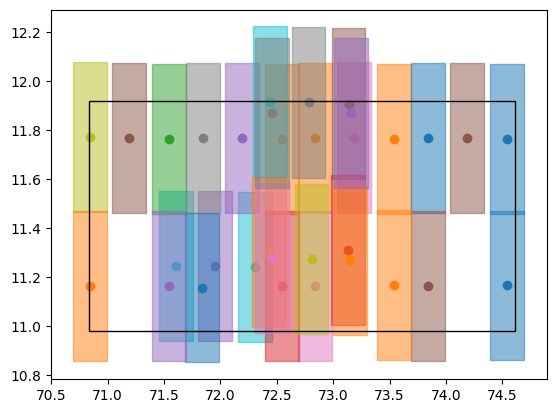

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()

ax = plt.subplot(111)

for i, row in overstacks.iterrows():
    # if i < 5:
    color = f"C{i}"
    
    width_deg = width / np.cos(np.radians(row["crval2"]))
    plt.scatter(row["crval1"], row["crval2"], color=color)

    rectangle = plt.Rectangle(
        (row["crval1"] - 0.5 * height, row["crval2"] - 0.5 * width_deg),
        height,
        width_deg,
        fc=color,
        alpha=0.5,
        ec=color,
    )
    ax.add_patch(rectangle)

# Add neutrino
rectangle = plt.Rectangle(
    (neutrino_ra_down, neutrino_dec_down),
    neutrino_ra_up-neutrino_ra_down,
    neutrino_dec_up-neutrino_dec_down,
    fc="none",
    ec="k",
)
ax.add_patch(rectangle)

# plt.show()


18.518206


(array([1., 1., 2., 2., 9., 9., 4., 0., 2., 3.]),
 array([17.45285  , 17.6593053, 17.8657606, 18.0722159, 18.2786712,
        18.4851265, 18.6915818, 18.8980371, 19.1044924, 19.3109477,
        19.517403 ]),
 <BarContainer object of 10 artists>)

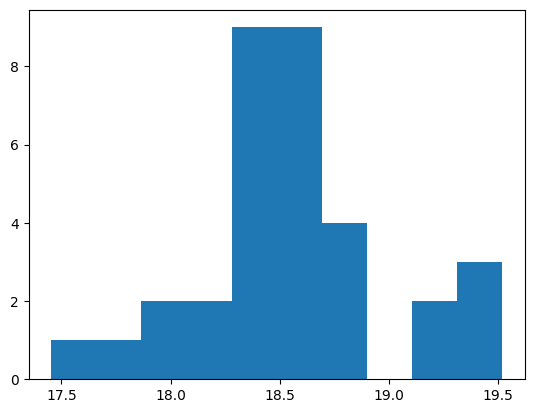

In [32]:
print(np.median(overstacks["maglim"]))
plt.hist(overstacks["maglim"])

In [33]:
overstacks[-8:]["savepath"].tolist()

['/data/loki/data/winter/20240106/final/WINTERcamera_20240107-024337-553_mef_1_0_0_stack.fits',
 '/data/loki/data/winter/20240106/final/WINTERcamera_20240107-024337-553_mef_5_0_0_stack.fits',
 '/data/loki/data/winter/20240106/final/WINTERcamera_20240107-024337-553_mef_2_0_0_stack.fits',
 '/data/loki/data/winter/20240105/final/WINTERcamera_20240106-052236-074_mef_4_0_0_stack.fits',
 '/data/loki/data/winter/20240105/final/WINTERcamera_20240106-052236-074_mef_3_0_0_stack.fits',
 '/data/loki/data/winter/20240105/final/WINTERcamera_20240106-052236-074_mef_1_0_0_stack.fits',
 '/data/loki/data/winter/20240105/final/WINTERcamera_20240106-052236-074_mef_5_0_0_stack.fits',
 '/data/loki/data/winter/20240105/final/WINTERcamera_20240106-052236-074_mef_2_0_0_stack.fits']

In [34]:
from astropy.time import Time

In [35]:
first = Time("2024-01-06T05:22:36", format="isot")
first

nu = Time("2024-01-05T12:27:42")
(first-nu).to(u.hour)

<Quantity 16.915 h>